# Simulação HHL no dispositivo quântico

Depth: 32
CNOTS: 10


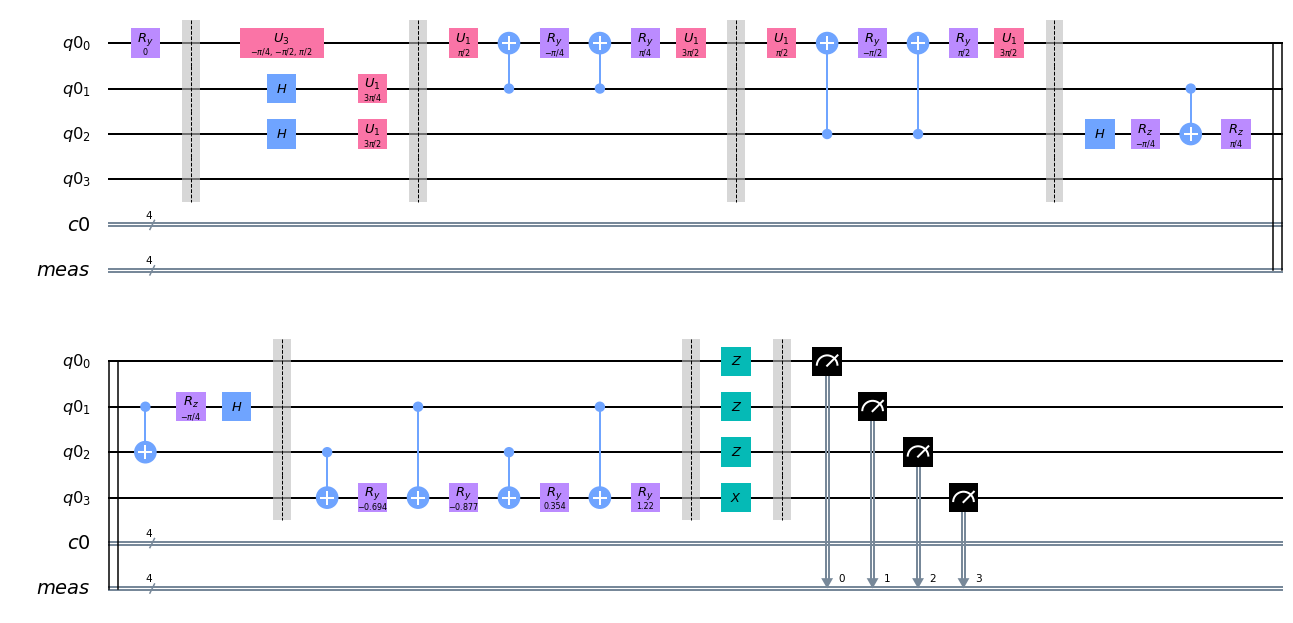

In [1]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
import numpy as np

t = 2*np.pi*3/8  # variável -> para fidelidade =1 , t = np.pi/3/4

nqubits = 4  # número total de qubits
nb = 1  # número de qubits representando a solução
nl = 2  # número de qubits representando os autovalores

theta = 0* np.pi  # ângulo de |b>

a = 1  # elementos diagonais da matriz
b = -1/3  # elementos não-diagonais da matrix

# Inicialização registradores
qr = QuantumRegister(nqubits)
qc = ClassicalRegister(4)

# Criação QC
qc = QuantumCircuit(qr,qc)

qrb = qr[0:nb]
qrl = qr[nb:nb+nl]
qra = qr[nb+nl:nb+nl+1]

# Preparação do estado
qc.ry(2*theta, qrb[0])
    
qc.barrier(qr[0], qr[1], qr[2], qr[3])
# QPE
for qu in qrl:
    qc.h(qu)

qc.u1(a*t, qrl[0])
qc.u1(a*t*2, qrl[1])

qc.u3(b*t, -np.pi/2, np.pi/2, qrb[0])

qc.barrier(qr[0], qr[1], qr[2], qr[3])
# Controle U = e^{iAt} -> \lambda_{1}:
params=b*t

qc.u1(np.pi/2,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(-params,qrb[0])
qc.u1(3*np.pi/2,qrb[0])

qc.barrier(qr[0], qr[1], qr[2], qr[3])
# Controle U = e^{2iAt} -> \lambda_{2}:
params = b*t*2

qc.u1(np.pi/2,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(-params,qrb[0])
qc.u1(3*np.pi/2,qrb[0])

qc.barrier(qr[0], qr[1], qr[2], qr[3])
# QFT Inversa
qc.h(qrl[1])
qc.rz(-np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(-np.pi/4,qrl[0])
qc.h(qrl[0])

qc.barrier(qr[0], qr[1], qr[2], qr[3])
# Rotação dos autovalores
t1=(-np.pi +np.pi/3 - 2*np.arcsin(1/3))/4
t2=(-np.pi -np.pi/3 + 2*np.arcsin(1/3))/4
t3=(np.pi -np.pi/3 - 2*np.arcsin(1/3))/4
t4=(np.pi +np.pi/3 + 2*np.arcsin(1/3))/4

qc.cx(qrl[1],qra[0])
qc.ry(t1,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t2,qra[0])
qc.cx(qrl[1],qra[0])
qc.ry(t3,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t4,qra[0])

qc.barrier(qr[0], qr[1], qr[2], qr[3])
# Observação
qc.z(qr[0])
qc.z(qr[1])
qc.z(qr[2])
qc.x(qr[3])
qc.measure_all()
#qc.z(qr[3])
#qc.measure(qr[3], 3) #medição apenas no ancilla

print("Depth: %i" % qc.depth())
print("CNOTS: %i" % qc.count_ops()['cx'])
qc.draw('mpl')

In [ ]:
from qiskit import *
from qiskit.compiler import transpile
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter, MeasurementFilter)

provider = IBMQ.load_account()
backend = provider.get_backend('ibmqx2') # provedor
simulator = Aer.get_backend('qasm_simulator') # simulador
layout = [2,3,0,4]
chip_qubits = 5

# decodificação do programa para utilizar funcoes de correção de erro no hardware
qc_qa_cx = transpile(qc, backend=backend, initial_layout=layout)

In [ ]:
# utilizar funções referentes ao erro de mitigação
meas_cals, state_labels = complete_meas_cal(qubit_list=layout, qr=QuantumRegister(chip_qubits))
qcs = meas_cals + [qc_qa_cx]

shots = 1000
job2 = execute(qcs, backend=backend, shots=shots, optimization_level=0) #medida utilizando funcoes de erro 
simulacao = execute(qc, backend=simulator, shots=shots, optimization_level=2).result() #medida simulacao
job = execute(qc, backend=backend, shots=shots, optimization_level=2) #medida convencional

In [ ]:
res1 = job.result()
res2 = job2.result()
ressim = simulacao.get_counts()
contagem = res1.get_counts()
contagem2 = res2.get_counts()

#contagem

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram([simulacao.get_counts(), contagem], legend = ['Simulador','Hardware real'])
#plot_histogram([simulacao.get_counts(), contagem, contagem2[-1]], legend = ['Simulador','Hardware real', 'Hardware real com correção'])
#plot_histogram([contagem, contagem2[-1]], legend = ['Hardware real', 'Hardware real com correção'])

In [ ]:
#res2 = job2.result()
#contagem2 = res2.get_counts()
#contagem2

In [ ]:
#plot_histogram(contagem2[-1])